In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!pip install Sastrawi
from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#PREPARE DATASET

In [3]:
df = pd.read_csv('/content/train_preprocess.tsv.txt', sep='\t', names=['text', 'label'])

df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [4]:
df.duplicated().sum()

67

In [5]:
df.drop_duplicates()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10993,f - demokrat dorong upaya kemandirian energi n...,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [6]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

#TEXT NORMALIZATION

In [7]:
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [8]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def word(cleaned_text):
    return word_tokenize(cleaned_text)
df['text_token'] = df['text'].apply(word)
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label,text_token
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,"[warung, ini, dimiliki, oleh, pengusaha, pabri..."
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,"[mohon, ulama, lurus, dan, k212, mmbri, hujjah..."
2,lokasi strategis di jalan sumatera bandung . t...,positive,"[lokasi, strategis, di, jalan, sumatera, bandu..."
3,betapa bahagia nya diri ini saat unboxing pake...,positive,"[betapa, bahagia, nya, diri, ini, saat, unboxi..."
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,"[duh, ., jadi, mahasiswa, jangan, sombong, don..."
...,...,...,...
10995,tidak kecewa,positive,"[tidak, kecewa]"
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,"[enak, rasa, masakan, nya, apalagi, kepiting, ..."
10997,hormati partai-partai yang telah berkoalisi,neutral,"[hormati, partai-partai, yang, telah, berkoalisi]"
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,"[pagi, pagi, di, tol, pasteur, sudah, macet, p..."


In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Mengonversi setiap list token menjadi string dan menggabungkannya
text = " ".join(" ".join(tokens) for tokens in df['text_token'])

# Membuat WordCloud
wordcloud = WordCloud().generate(text)

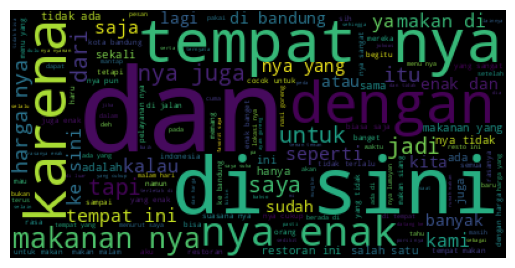

In [10]:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
#menghilangkat kata-kata yang tidak terlalu di perlukan
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Unduh kamus kata-kata stop words Bahasa Indonesia
nltk.download('stopwords')
nltk.download('punkt')  # Unduh data tokenisasi

# Inisialisasi set stop words
wordlist = set(stopwords.words('indonesian'))

# Membuat set kata-kata tambahan
additional_stopwords = set([
    "yg", "dg", "rt", "dgn", "ny", "d", 'klo', 'kalo', 'amp',
    'biar', 'bikin', 'bilang', 'gak', 'ga', 'krn', 'nya', 'nih',
    'sih', 'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 'jd', 'jgn',
    'sdh', 'aja', 'n', 't', 'nyg', 'hehe', 'pen', 'u', 'nan',
    'loh', 'user', 'bukan', 'hanya', 'kata', 'gua', '&amp', 'yah'
    , 'orang', 'lu', 'url', 'gue', 'tp', 'gw', 'udah', 'lo', 'url'
    , 'dah', 'jg', 'org', 'emang', 'pake', 'no'
    , 'pa','ni','mah','iya','bgt','tu','gk','liat','mas','cak'
])

# Gabungkan set stop words NLTK dan set kata-kata tambahan
list_stopwords = wordlist.union(additional_stopwords)

# Buat DataFrame df sesuai dengan kebutuhan Anda

# Membuat fungsi untuk menghapus stop words
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

# Menggunakan word_tokenize untuk membagi teks menjadi token
tokenizer = word_tokenize
df['text_token'] = df['text'].apply(lambda text: tokenizer(text))

# Menghapus stop words dan kata-kata tambahan
df['text_remove_stopwords'] = df['text_token'].apply(stopwords_removal)

# Menggabungkan token-token menjadi satu string
df['text_remove_stopwords'] = df['text_remove_stopwords'].apply(lambda tokens: ' '.join(tokens))

# Tampilkan DataFrame yang telah diproses
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label,text_token,text_remove_stopwords
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,"[mohon, ulama, lurus, dan, k212, mmbri, hujjah...",mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,"[lokasi, strategis, di, jalan, sumatera, bandu...",lokasi strategis jalan sumatera bandung . nyam...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",betapa bahagia unboxing paket barang bagus ! m...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,"[duh, ., jadi, mahasiswa, jangan, sombong, don...",duh . mahasiswa sombong . kasih kartu kuning ....
...,...,...,...,...
10995,tidak kecewa,positive,"[tidak, kecewa]",kecewa
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,"[enak, rasa, masakan, nya, apalagi, kepiting, ...",enak masakan kepiting menyenangkan memilih kep...
10997,hormati partai-partai yang telah berkoalisi,neutral,"[hormati, partai-partai, yang, telah, berkoalisi]",hormati partai-partai berkoalisi
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,"[pagi, pagi, di, tol, pasteur, sudah, macet, p...","pagi pagi tol pasteur macet parah , jengkel"


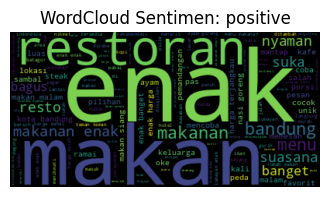

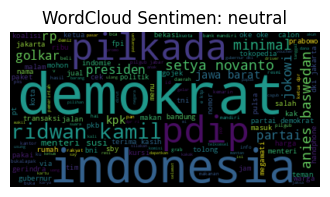

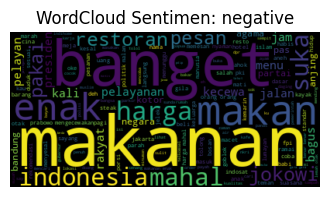

In [12]:
for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['text_remove_stopwords'])

    # Membuat WordCloud
    wordcloud = WordCloud().generate(text)

    # Menampilkan WordCloud
    plt.figure(figsize=(4,3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud Sentimen: {label}")
    plt.axis("off")
    plt.show()

In [13]:
from wordcloud import WordCloud

# Mengonversi setiap list token menjadi string dan menggabungkannya
text = " ".join(df['text_remove_stopwords'])

# Membuat WordCloud
wordcloud = WordCloud().generate(text)

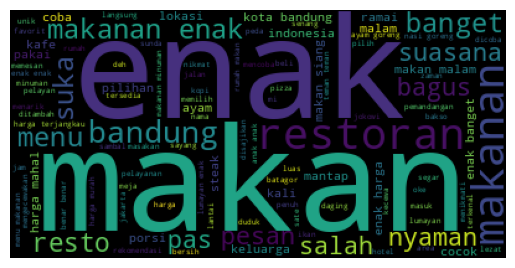

In [14]:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [15]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [16]:
# sortir data masing-masing data label
neg = df.loc[df['label'] == 'negative']['text_remove_stopwords'].tolist()
neu = df.loc[df['label'] == 'neutral']['text_remove_stopwords'].tolist()
pos = df.loc[df['label'] == 'positive']['text_remove_stopwords'].tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral']. label.tolist()
pos_label = df.loc[df['label'] == 'positive']. label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('positive: %s, neutral: %s, negative: %s' % (len(pos), len(neu), len(neg)))
print('total data: %s' % len(total_data))

positive: 6416, neutral: 1148, negative: 3436
total data: 11000


<Axes: ylabel='label'>

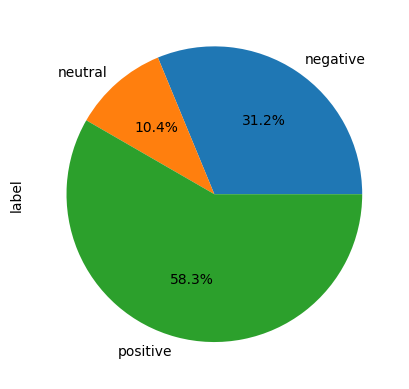

In [17]:
count_label = df.groupby('label').label.count()
count_label
count_label.plot(kind='pie', autopct='%1.1f%%')

#FEATURE EXTRACTION

##TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

data_preprocessed = df.text_remove_stopwords.tolist()

In [19]:
# Proses Feature Extraction
tfidf_vect = TfidfVectorizer()

X = tfidf_vect.fit_transform(data_preprocessed)
print("Feature Extraction selesai")

Feature Extraction selesai


In [20]:
tfidf_array = X.toarray()
df_array = pd.DataFrame(data=tfidf_array,columns = tfidf_vect.get_feature_names_out())
print(df_array)

        00  000  001   01  010  0111  011770465655617   02  021  022  ...  \
0      0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
1      0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
2      0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
3      0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
4      0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
...    ...  ...  ...  ...  ...   ...              ...  ...  ...  ...  ...   
10995  0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
10996  0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
10997  0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
10998  0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   
10999  0.0  0.0  0.0  0.0  0.0   0.0              0.0  0.0  0.0  0.0  ...   

       zonpoliticon  zoo  zoom  zubir  zulfikri  zulkarnain  zup  zupa  zup

#Prepare train and test dataset (split dataset)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# save output feature in variable classes
classes = df.label

# split dataset to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size = 0.2)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8800, 16754)
(2200, 16754)
(8800,)
(2200,)


#MODEL TRAINING

##NEURAL NETWORK

In [24]:
from sklearn.neural_network import MLPClassifier #load library neural network

In [25]:
# model training menggunakan neural network
model = MLPClassifier()
model.fit(X_train, y_train)

print("Training selesai")

# save model to pickle
pickle.dump(model, open("model_neuralnetwork.p", "wb"))

Training selesai


##MODEL EVALUATION

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
test = model.predict(X_test)
print ("Testing selesai")
print(classification_report(y_test, test))

Testing selesai
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72       685
     neutral       0.79      0.54      0.64       228
    positive       0.85      0.90      0.87      1287

    accuracy                           0.80      2200
   macro avg       0.79      0.72      0.74      2200
weighted avg       0.80      0.80      0.80      2200



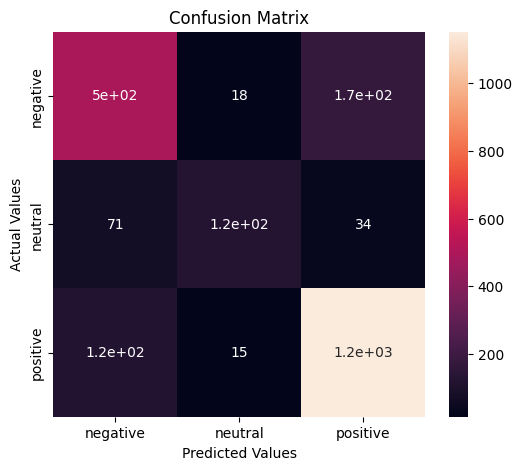

In [28]:
cm = confusion_matrix(y_test, test, labels=["negative", "neutral", "positive"])

cm_df = pd.DataFrame(cm,
                     index =["negative", "neutral", "positive"],
                     columns =["negative", "neutral", "positive"])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

##CROSS VALIDATION

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from statistics import mean, stdev

In [30]:
X = df[["text_remove_stopwords"]] # input feature
Y = df["label"] # output feature

# split dataset to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [31]:
# cross validation dengan split = 5
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies=[]

X_train = X_train.reset_index().text_remove_stopwords
y_train = y_train.reset_index().label

In [32]:
def cross_validation(k, X_train, model, name):
  accuracies = []
  precisions = []
  recalls = []
  f1_scores = []

  # iterate sebanyak k cross validation
  for iteration, data in enumerate(kf.split(X_train), start=1):
      # get data and target train
      data_train = X_train[data[0]]
      tfidf_vect = TfidfVectorizer()
      data_train = tfidf_vect.fit_transform(data_train)

      target_train = y_train[data[0]]

      # get data and target test
      data_test =  X_train[data[1]]
      data_test = tfidf_vect.transform(data_test)

      target_test =  y_train[data[1]]

      # model training menggunakan data train
      classifier = model
      classifier.fit(data_train, target_train)

      # prediksi data test
      preds = classifier.predict(data_test)

      # menghitung accuracy
      accuracy = accuracy_score(target_test, preds)
      precision = precision_score(target_test, preds, average='weighted')
      recall = recall_score(target_test, preds, average='weighted')
      f1 = f1_score(target_test, preds, average='weighted')

      print("Training ke-", iteration)
      print(classification_report(target_test, preds))
      print("=================================================================")

      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1_scores.append(f1)

  result = {'algorithm': name,
                'accuracy_per_iter': accuracies, 'accuracy_mean': mean(accuracies), 'accuracy_std': stdev(accuracies),
                'recall_mean': mean(recalls),'precision_mean': mean(precisions), 'f1_mean': mean(f1_scores)}
  return result

In [33]:
result = cross_validation(5, X_train, MLPClassifier(), "Neural Network")
result

Training ke- 1
              precision    recall  f1-score   support

    negative       0.70      0.77      0.73       531
     neutral       0.77      0.57      0.66       166
    positive       0.87      0.86      0.87      1063

    accuracy                           0.81      1760
   macro avg       0.78      0.74      0.75      1760
weighted avg       0.81      0.81      0.81      1760

Training ke- 2
              precision    recall  f1-score   support

    negative       0.73      0.69      0.71       547
     neutral       0.84      0.59      0.69       201
    positive       0.83      0.90      0.86      1012

    accuracy                           0.80      1760
   macro avg       0.80      0.73      0.76      1760
weighted avg       0.80      0.80      0.80      1760

Training ke- 3
              precision    recall  f1-score   support

    negative       0.73      0.72      0.73       547
     neutral       0.72      0.60      0.65       178
    positive       0.85      0

{'algorithm': 'Neural Network',
 'accuracy_per_iter': [0.8079545454545455,
  0.8005681818181818,
  0.803409090909091,
  0.8096590909090909,
  0.7965909090909091],
 'accuracy_mean': 0.8036363636363637,
 'accuracy_std': 0.00533909543674251,
 'recall_mean': 0.8036363636363637,
 'precision_mean': 0.8027930095791714,
 'f1_mean': 0.8010166274799179}

##Select model Neural Network

In [34]:
# convert to feature
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(df["text_remove_stopwords"])
X_train, X_test, y_train, y_test = train_test_split(X, df["label"], test_size=0.2)

# model training menggunakan neural network
model = MLPClassifier()
model.fit(X_train, y_train)

print("Training selesai")

# save model to pickle
pickle.dump(model, open("model_classification.p", "wb"))

Training selesai


In [35]:
test = model.predict(X_test)
print ("Testing selesai")
print(classification_report(y_test, test))

Testing selesai
              precision    recall  f1-score   support

    negative       0.73      0.69      0.71       727
     neutral       0.74      0.56      0.64       197
    positive       0.83      0.89      0.86      1276

    accuracy                           0.79      2200
   macro avg       0.77      0.71      0.73      2200
weighted avg       0.79      0.79      0.79      2200



##PREDIKSI DATA BARU

In [36]:
input_text = "pagi pagi di tol pasteur sudah macet parah"

# normalize text
text= tfidf_vect.transform([cleansing(input_text)])

# predict data baru menggunakan model yang telah dibuat
result = model.predict(text)[0]

print("Sentiment:", result)

Sentiment: negative
